<a href="https://colab.research.google.com/github/DaiVo20/za_traffic_detection/blob/main/keras_retinanet/model_with_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import library**

In [ ]:
!git clone https://github.com/DaiVo20/za_traffic_detection

Cloning into 'za_traffic_detection'...
remote: Enumerating objects: 249, done.
remote: Counting objects: 100% (249/249), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 249 (delta 77), reused 184 (delta 39), pack-reused 0
Receiving objects: 100% (249/249), 38.06 MiB | 38.10 MiB/s, done.
Resolving deltas: 100% (77/77), done.


In [ ]:
import os
import cv2
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.data import TFRecordDataset
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from za_traffic_detection.keras_retinanet.retinanet.utils import try_ignore_error
from za_traffic_detection.keras_retinanet.retinanet.losses import RetinaNetLoss
from za_traffic_detection.keras_retinanet.retinanet.model import LabelEncoder, RetinaNet
import za_traffic_detection.keras_retinanet.retinanet.model as m
from za_traffic_detection.keras_retinanet.retinanet.prediction import Prediction
from za_traffic_detection.keras_retinanet.retinanet.data_processing import write_tfrecords, DataProcessing
from za_traffic_detection.keras_retinanet.retinanet.utils import visualize_detections

# **Prepare data**

In [ ]:
df_train_augmentation = pd.read_csv('/content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/train_augmentation.csv', header=None)
df_train_augmentation.columns = ['file_name', 'xmin', 'ymin', 'xmax', 'ymax', 'class']

In [ ]:
sign_to_index = {
    "No entry": 1,
    "No parking / waiting": 2,
    "No turning": 3,
    "Max Speed": 4,
    "Other prohibition signs": 5,
    "Warning": 6,
    "Mandatory": 7
}

df_train_augmentation['width'] = df_train_augmentation['xmax'] - df_train_augmentation['xmin']
df_train_augmentation['height'] = df_train_augmentation['ymax'] - df_train_augmentation['ymin']
df_train_augmentation["label"] = df_train_augmentation['class'].replace(sign_to_index)

In [ ]:
df_train_augmentation

,file_name,xmin,ymin,xmax,ymax,class,width,height,label
0,/content/drive/MyDrive/TrafficSign/Model/Retin...,70,19,89,37,No parking / waiting,19,18,2
1,/content/drive/MyDrive/TrafficSign/Model/Retin...,259,41,342,124,No turning,83,83,3
2,/content/drive/MyDrive/TrafficSign/Model/Retin...,376,23,393,38,Warning,17,15,6
3,/content/drive/MyDrive/TrafficSign/Model/Retin...,214,2,289,74,No parking / waiting,75,72,2
4,/content/drive/MyDrive/TrafficSign/Model/Retin...,290,0,328,22,Other prohibition signs,38,22,5
...,...,...,...,...,...,...,...,...,...
27845,/content/drive/MyDrive/TrafficSign/Model/Retin...,147,69,194,116,Mandatory,47,47,7
27846,/content/drive/MyDrive/TrafficSign/Model/Retin...,297,118,317,137,No turning,20,19,3
27847,/content/drive/MyDrive/TrafficSign/Model/Retin...,92,0,365,76,Mandatory,273,76,7
27848,/content/drive/MyDrive/TrafficSign/Model/Retin...,123,15,171,56,No parking / waiting,48,41,2


In [ ]:
data_train = []

for index, row in tqdm(df_train_augmentation.iterrows()):
    item = {}
    image_id = row['file_name'].split('/')[-1].split('.')[0]
    bbox = [row['xmin'], row['ymin'], row['width'], row['height']]
    label = row['label']

    item['id'] = image_id
    item['bbox'] = bbox
    item['label'] = label

    data_train.append(item)

27850it [00:02, 10403.19it/s]


In [ ]:
TFRECORDS_FILE = '/content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/images_data_augmentation.tfrecords'
path_images = '/content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/images'
checkpoint_dir = '/content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/weights'
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
if not os.path.exists(TFRECORDS_FILE):
    print("Creating tfrecords dataset...")
    write_tfrecords(data_train, TFRECORDS_FILE, path_images)

Creating tfrecords dataset...


100%|██████████| 27850/27850 [1:23:16<00:00,  5.57it/s]


In [ ]:
autotune = tf.data.experimental.AUTOTUNE
batch_size = 10

fdataset = TFRecordDataset(TFRECORDS_FILE)
data_processor = DataProcessing(origin_width=405, origin_height=156, width=400, height=154)
label_encoder = LabelEncoder()

In [ ]:
train_data = fdataset.map(data_processor.preprocess_data)
train_data = train_data.shuffle(batch_size)
train_data = train_data.padded_batch(batch_size, padding_values=(0.0, 1e-8, tf.cast(-1, tf.int64)), drop_remainder=True)
train_data = train_data.map(label_encoder.encode_batch, num_parallel_calls=autotune)
train_data = train_data.apply(tf.data.experimental.ignore_errors())
train_data = train_data.prefetch(autotune)

# **Train model**

In [ ]:
number_class = 7
train_size = 4500
train_steps_per_epoch = train_size // batch_size
epochs = 50

In [ ]:
learning_rates = [1e-4, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = PiecewiseConstantDecay(boundaries=learning_rate_boundaries, values=learning_rates)
optimizer = SGD(learning_rate=learning_rate_fn, momentum=0.9)

callbacks_list = [
    ModelCheckpoint(
        filepath = os.path.join(checkpoint_dir, 'weight_resnet50_{epoch}.h5'),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=3,
    )
]

model = RetinaNet(number_class, backbone="resnet50")
model.compile(optimizer=optimizer, loss=RetinaNetLoss(number_class))
model.build((1, None, None, 3))

In [ ]:
path_weight = os.path.join(checkpoint_dir, 'weight_resnet50.h5')
try_ignore_error(model.load_weights, path_weight)

In [ ]:
history = model.fit(train_data.repeat(),
                    epochs=epochs,
                    steps_per_epoch=train_steps_per_epoch,
                    callbacks=callbacks_list,
                    initial_epoch=0)

Epoch 1/50
1849/1849 [==============================] - ETA: 0s - loss: 1.7261
Epoch 00001: saving model to /content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/weights/weight_resnet50.h5
1849/1849 [==============================] - 3090s 2s/step - loss: 1.7261
Epoch 2/50
1849/1849 [==============================] - ETA: 0s - loss: 0.5567
Epoch 00002: saving model to /content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/weights/weight_resnet50.h5
1849/1849 [==============================] - 3025s 2s/step - loss: 0.5567
Epoch 3/50
1849/1849 [==============================] - ETA: 0s - loss: 0.4233
Epoch 00003: saving model to /content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/weights/weight_resnet50.h5
1849/1849 [==============================] - 3007s 2s/step - loss: 0.4233
Epoch 4/50
1849/1849 [==============================] - ETA: 0s - loss: 0.3523
Epoch 00004: saving model to /content/drive/MyDrive/Traff

In [ ]:
history = model.fit(train_data.repeat(),
                    epochs=epochs,
                    steps_per_epoch=train_steps_per_epoch,
                    callbacks=callbacks_list,
                    initial_epoch=5)

Epoch 6/50
1849/1849 [==============================] - ETA: 0s - loss: 0.2325
Epoch 00006: saving model to /content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/weights/weight_resnet50.h5
1849/1849 [==============================] - 3066s 2s/step - loss: 0.2325
Epoch 7/50
1849/1849 [==============================] - ETA: 0s - loss: 0.2052
Epoch 00007: saving model to /content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/weights/weight_resnet50.h5
1849/1849 [==============================] - 3044s 2s/step - loss: 0.2052
Epoch 8/50
1849/1849 [==============================] - ETA: 0s - loss: 0.1979
Epoch 00008: saving model to /content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/weights/weight_resnet50.h5
1849/1849 [==============================] - 3042s 2s/step - loss: 0.1979
Epoch 9/50
1849/1849 [==============================] - ETA: 0s - loss: 0.1808
Epoch 00009: saving model to /content/drive/MyDrive/Traff

In [ ]:
history = model.fit(train_data.repeat(),
                    epochs=epochs,
                    steps_per_epoch=train_steps_per_epoch,
                    callbacks=callbacks_list,
                    initial_epoch=11)

Epoch 12/50
1849/1849 [==============================] - ETA: 0s - loss: 0.1499
Epoch 00012: saving model to /content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/weights/weight_resnet50.h5
1849/1849 [==============================] - 3056s 2s/step - loss: 0.1499
Epoch 13/50
1849/1849 [==============================] - ETA: 0s - loss: 0.1333
Epoch 00013: saving model to /content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/weights/weight_resnet50.h5
1849/1849 [==============================] - 3040s 2s/step - loss: 0.1333
Epoch 14/50
1849/1849 [==============================] - ETA: 0s - loss: 0.1316
Epoch 00014: saving model to /content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/weights/weight_resnet50.h5
1849/1849 [==============================] - 3037s 2s/step - loss: 0.1316
Epoch 15/50
1849/1849 [==============================] - ETA: 0s - loss: 0.1265
Epoch 00015: saving model to /content/drive/MyDrive/T

In [ ]:
history = model.fit(train_data.repeat(),
                    epochs=epochs,
                    steps_per_epoch=train_steps_per_epoch,
                    callbacks=callbacks_list,
                    initial_epoch=15)

Epoch 16/50
1849/1849 [==============================] - ETA: 0s - loss: 0.1189
Epoch 00016: saving model to /content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/weights/weight_resnet50.h5
1849/1849 [==============================] - 2992s 2s/step - loss: 0.1189
Epoch 17/50
1849/1849 [==============================] - ETA: 0s - loss: 0.1089
Epoch 00017: saving model to /content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/weights/weight_resnet50.h5
1849/1849 [==============================] - 2969s 2s/step - loss: 0.1089
Epoch 18/50
1849/1849 [==============================] - ETA: 0s - loss: 0.1113
Epoch 00018: saving model to /content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/weights/weight_resnet50.h5
1849/1849 [==============================] - 2968s 2s/step - loss: 0.1113
Epoch 19/50
1849/1849 [==============================] - ETA: 0s - loss: 0.1060
Epoch 00019: saving model to /content/drive/MyDrive/T

In [ ]:
history = model.fit(train_data.repeat(),
                    epochs=epochs,
                    steps_per_epoch=train_steps_per_epoch,
                    callbacks=callbacks_list,
                    initial_epoch=19)

Epoch 20/50
1849/1849 [==============================] - ETA: 0s - loss: 0.1034
Epoch 00020: saving model to /content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/weights/weight_resnet50.h5
1849/1849 [==============================] - 3215s 2s/step - loss: 0.1034
Epoch 21/50
1405/1849 [=====================>........] - ETA: 12:47 - loss: 0.0975

In [ ]:
history = model.fit(train_data.repeat(),
                    epochs=epochs,
                    steps_per_epoch=train_steps_per_epoch,
                    callbacks=callbacks_list,
                    initial_epoch=20)

Epoch 21/50
1849/1849 [==============================] - ETA: 0s - loss: 0.1016
Epoch 00021: saving model to /content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/weights/weight_resnet50.h5
1849/1849 [==============================] - 2965s 2s/step - loss: 0.1016
Epoch 22/50
1849/1849 [==============================] - ETA: 0s - loss: 0.0952
Epoch 00022: saving model to /content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/weights/weight_resnet50.h5
1849/1849 [==============================] - 2941s 2s/step - loss: 0.0952
Epoch 23/50
1849/1849 [==============================] - ETA: 0s - loss: 0.1002
Epoch 00023: saving model to /content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/weights/weight_resnet50.h5
1849/1849 [==============================] - 2941s 2s/step - loss: 0.1002
Epoch 24/50
1849/1849 [==============================] - ETA: 0s - loss: 0.0938
Epoch 00024: saving model to /content/drive/MyDrive/T

# **Evaluate**

In [ ]:
def get_inference_model(weight_path, confidence_threshold=0.05, nms_iou_threshold=0.5, backbone="resnet50"):
    num_of_classes = 7
    model = RetinaNet(num_of_classes, backbone=backbone)
    model.compile(optimizer="adam", loss=RetinaNetLoss(num_of_classes))
    model.build((1, None, None, 3))
    image = tf.keras.Input(shape=[None, None, 3], name="image")
    model.load_weights(weight_path)
    predictions = model(image, training=False)
    detections = m.DecodePredictions(confidence_threshold=confidence_threshold,
                                     num_classes=num_of_classes,
                                     max_detections_per_class=10,
                                     nms_iou_threshold=nms_iou_threshold,
                                     verbose=0)(image, predictions)

    inference_model = tf.keras.Model(inputs=image, outputs=detections)

    return inference_model

## **Single**

In [ ]:
df_test_croped = pd.read_csv('/content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/image_crop/traffic_public_test/test_croped.csv')
image_names = df_test_croped['file_name'].unique()

In [ ]:
index_class = {
    1: "no_entry",
    2: "no_parking_waiting",
    3: "no_turning",
    4: "max_speed",
    5: "other_prohibition_signs",
    6: "warning",
    7: "mandatory"
}

In [ ]:
path_save_label = '/content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/label'
os.makedirs(path_save_label, exist_ok=True)

path_save_predict = '/content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/predict'
os.makedirs(path_save_predict, exist_ok=True)

In [ ]:
df_test_copy = df_test_croped.copy()
df_test_copy['class_'] = df_test_copy['label'].replace(index_class)

grouped = df_test_copy.groupby(df_test_copy.file_name)
for file_name in tqdm(image_names):
    img_name = file_name.split('/')[-1].split('.')[0]
    item = grouped.get_group(file_name)
    item = item.loc[:,['xmin', 'ymin', 'width', 'height', 'class_']]
    item = item.reindex(columns=['class_', 'xmin', 'ymin', 'width', 'height'])
    item.to_csv(os.path.join(path_save_label, img_name + '.txt'), sep=' ', index=False, header=None)

100%|██████████| 574/574 [01:43<00:00,  5.53it/s]


In [ ]:
path_weight = '/content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/weights/weight_resnet50.h5'
inference_model = get_inference_model(path_weight, confidence_threshold=0.05, backbone='resnet50')
predictor = Prediction(inference_model)

In [ ]:
for index, file_name in tqdm(enumerate(image_names)):
    img_name = file_name.split('/')[-1].split('.')[0]
    dict_predict = {'class':[], 'confidence':[], 'x':[], 'y':[], 'w':[], 'h':[]}
    img = cv2.imread(file_name)[..., ::-1]
    image, boxes, scores, classes = predictor.detect_single_image(img)
    for box, score, class_ in zip(boxes, scores, classes):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        confidence = score.numpy()

        dict_predict['class'].append(index_class[class_.numpy().astype(int)])
        dict_predict['confidence'].append(confidence)
        dict_predict['x'].append(round(x1.numpy(), 0).astype(int))
        dict_predict['y'].append(round(y1.numpy(), 0).astype(int))
        dict_predict['w'].append(round(w.numpy(), 0).astype(int))
        dict_predict['h'].append(round(h.numpy(), 0).astype(int))
    
    pd.DataFrame(dict_predict).to_csv(os.path.join(path_save_predict, img_name + '.txt'), sep=' ', index=False, header=None)

574it [01:31,  6.27it/s]


In [ ]:
!python /content/za_traffic_detection/keras_retinanet/evaluation/pascalvoc.py -gt /content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/label -det /content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/predict -t



###########################################################################################
#                                                                                         #
# This sample shows how to evaluate object detections applying the following metrics:     #
#  * Precision x Recall curve       ---->       used by VOC PASCAL 2012)                  #
#  * Average Precision (AP)         ---->       used by VOC PASCAL 2012)                  #
#                                                                                         #
# Developed by: Rafael Padilla (rafael.padilla@smt.ufrj.br)                               #
#        SMT - Signal Multimedia and Telecommunications Lab                               #
#        COPPE - Universidade Federal do Rio de Janeiro                                   #
#        Last modification: Feb 12th 2021                                                 #
##############################################################################

## **Combine**

In [ ]:
path_save_label = '/content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/label_combine'
os.makedirs(path_save_label, exist_ok=True)

path_save_predict = '/content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/predict_combine'
os.makedirs(path_save_predict, exist_ok=True)

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/TrafficSign/data/za_traffic_2020/traffic_public_test/test.csv')
df_test['width'] = df_test['xmax'] - df_test['xmin']
df_test['height'] = df_test['ymax'] - df_test['ymin']
df_test['class_'] = df_test['label'].replace(index_class)
image_names = df_test.file_name.unique()

grouped = df_test.groupby(df_test.file_name)
for file_name in tqdm(image_names):
    img_name = file_name.split('/')[-1].split('.')[0]
    item = grouped.get_group(file_name)
    item = item.loc[:,['xmin', 'ymin', 'width', 'height', 'class_']]
    item = item.reindex(columns=['class_', 'xmin', 'ymin', 'width', 'height'])
    item.to_csv(os.path.join(path_save_label, img_name + '.txt'), sep=' ', index=False, header=None)

100%|██████████| 568/568 [00:04<00:00, 138.06it/s]


In [ ]:
path_weight = '/content/drive/MyDrive/TrafficSign/Model/RetinaNet/train_model/weights/weight_resnet50.h5'
inference_model = get_inference_model(path_weight, confidence_threshold=0.05, backbone='resnet50')
predictor = Prediction(inference_model)

In [ ]:
path_image = '/content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/image_crop/traffic_public_test_all/images'
image_crop_names = os.listdir(path_image)
WIDTH = 405
HEIGHT = 156

dict_predict = {'class':[], 'confidence':[], 'x':[], 'y':[], 'w':[], 'h':[]}
for index, image_name in tqdm(enumerate(image_crop_names)):
    if (index + 1) % 16 == 0:
        pd.DataFrame(dict_predict).to_csv(os.path.join(path_save_predict, name + '.txt'), sep=' ', index=False, header=None)
        dict_predict = {'class':[], 'confidence':[], 'x':[], 'y':[], 'w':[], 'h':[]}
    ele_name = image_name.split('/')[-1].split('.')[0].split('_')
    name = ele_name[0]
    column = ele_name[1]
    row = ele_name[2]

    img = cv2.imread(os.path.join(path_image, image_name))[..., ::-1]
    image, boxes, scores, classes = predictor.detect_single_image(img, tiling=False)
    for box, score, class_ in zip(boxes, scores, classes):
        x1, y1, x2, y2 = box
        x_new = round(x1.numpy(), 0).astype(int) + int(row)*WIDTH
        y_new = round(y1.numpy(), 0).astype(int) + int(column)*HEIGHT
        w, h = x2 - x1, y2 - y1
        confidence = score.numpy()

        dict_predict['class'].append(index_class[class_.numpy().astype(int)])
        dict_predict['confidence'].append(confidence)
        dict_predict['x'].append(x_new)
        dict_predict['y'].append(y_new)
        dict_predict['w'].append(round(w.numpy(), 0).astype(int))
        dict_predict['h'].append(round(h.numpy(), 0).astype(int))

9088it [24:04,  6.29it/s]


In [ ]:
!python /content/za_traffic_detection/keras_retinanet/evaluation/pascalvoc.py -gt /content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/label_combine -det /content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/data_augmentation/predict_combine



###########################################################################################
#                                                                                         #
# This sample shows how to evaluate object detections applying the following metrics:     #
#  * Precision x Recall curve       ---->       used by VOC PASCAL 2012)                  #
#  * Average Precision (AP)         ---->       used by VOC PASCAL 2012)                  #
#                                                                                         #
# Developed by: Rafael Padilla (rafael.padilla@smt.ufrj.br)                               #
#        SMT - Signal Multimedia and Telecommunications Lab                               #
#        COPPE - Universidade Federal do Rio de Janeiro                                   #
#        Last modification: Feb 12th 2021                                                 #
##############################################################################

# **Predict**

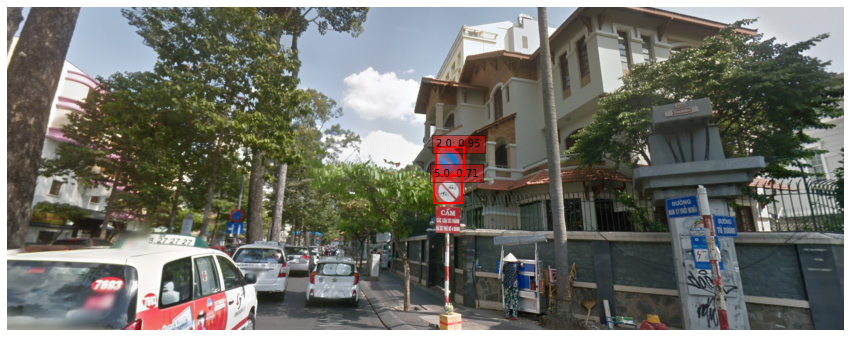

In [ ]:
path_img = os.path.join('/content/drive/MyDrive/TrafficSign/data/za_traffic_2020/traffic_public_test/images', '122.png')
img = cv2.imread(path_img)[..., ::-1]
image, boxes, scores, classes = predictor.detect_single_image(img)
visualize_detections(image, boxes, classes, scores)